# Part 2: SQLAlchemy Practice on a Business Database:  

---

By Jean-Yves Tran | jy.tran@[datascience-jy.com](https:datascience-jy.com) | [LinkedIn](https://www.linkedin.com/in/jytran-datascience/)  
IBM Certified Data Analyst 

---

Continuing on the first exploration and analysis ([click here](https://github.com/jendives2000/Data_ML_Practice_2025/blob/main/1-3-SQL/practice/dvd_rental/PostGreSQL_SQLALchemy_Business_Database_dvdrental_1.ipynb)) I do not dive deeper into the database, this is more of an SQL refresher where I am revisiting queries that usually give trouble to users. These are often named "Non-Trivial" SQL queries, underlining the fact that they are above simple and easy:  

- Filtering with subqueries and NOT:
  - with multiple where clauses
  - or by JOINing multiple attributes with just one unique JOIN

I also visit what is a dynamic computation in a query, which is the solution to hard coding a specific value.

### Imports: 

In [3]:
from sqlalchemy import create_engine, cast, alias, select, and_, extract, union, literal, nullsfirst, func, Time, Table, MetaData, Date
from datetime import date
from dotenv import load_dotenv
import os
from pathlib import Path
from shared_code import execute_stmt

In [4]:
# Get the current working directory
current_dir = os.getcwd()

### .env file:  

Securing PostGreSQL credentials.

In [5]:
# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the .env file
env_path = Path(current_dir).parents[2] / ".env"
print(f".env file exists: {env_path.exists()}")

# Load environment variables from the .env file
load_dotenv(dotenv_path=env_path)

.env file exists: True


True

### Setup of the Connection:

Connecting to the PostGreSQL database dvdrental using SQLAlchemy Core approach. 

In [6]:
# Define the PostgreSQL database URL from environment variables
DATABASE_URL = os.getenv("DATABASE_URL")

# Create the SQLAlchemy engine
engine = create_engine(DATABASE_URL)

# Create a MetaData instance
metadata_obj = MetaData()

<a id="er-diagram"></a>
## ER Diagram of the dvdrental database: 
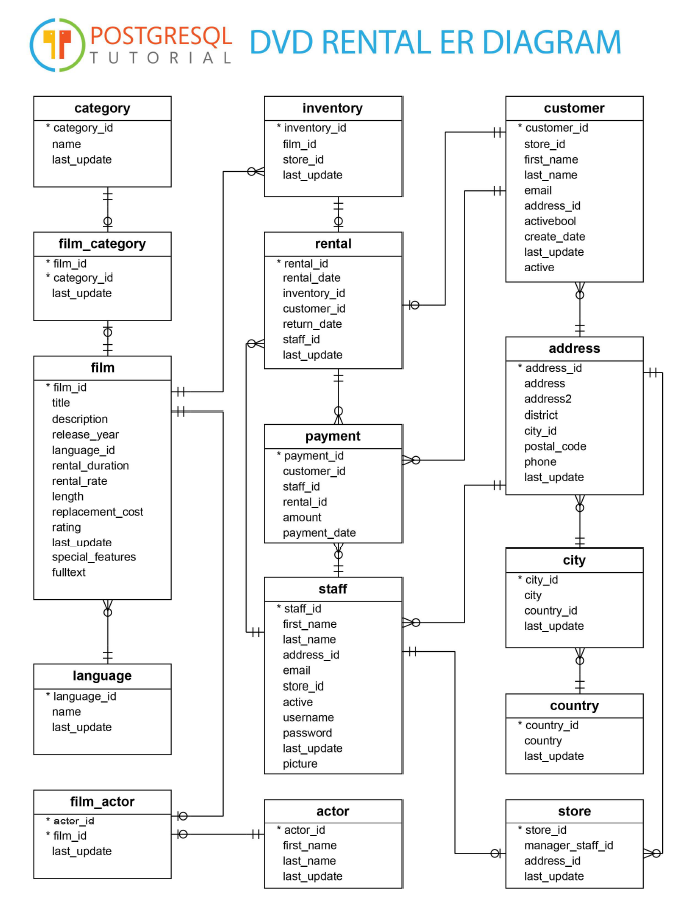


---


In [7]:
# Reflecting the film table: 
film = Table('film', metadata_obj, autoload_with=engine)

## Subqueries: 

Very useful for filtering in queries without the need to use multiple where clauses.  

I start by checking the whole film table just to remind myself about its columns. I need to see the replacement_cost column. 

In [11]:
f = film
frc = f.c.replacement_cost

stmt = select(frc).limit(10)

execute_stmt(stmt, engine)


Total rows returned: 10

Raw SQL query:
SELECT film.replacement_cost 
FROM film 
 LIMIT %(param_1)s

replacement_cost
14.99
19.99
15.99
12.99
20.99
12.99
18.99
26.99
22.99
17.99


What about the average of the whole column?

In [12]:
stmt = select(
    func.avg(frc).label('average_replacement_cost')
)
execute_stmt(stmt, engine)


Total rows returned: 1

Raw SQL query:
SELECT avg(film.replacement_cost) AS average_replacement_cost 
FROM film

average_replacement_cost
19.9840000000000000


I was requested to add readability to that replacement cost in the film table. For that I want to add columns with the value "above" when the rc is above average, and as well the value below. 

So here is a mistake we usually do. Hard coding the filtering in a where clause:

In [15]:
stmt = select(
    frc).where(
        f.c.replacement_cost > 19.984  # hard coded value
    )
execute_stmt(stmt, engine)


Total rows returned: 536

Raw SQL query:
SELECT film.replacement_cost 
FROM film 
WHERE film.replacement_cost > %(replacement_cost_1)s

replacement_cost
19.99
20.99
26.99
22.99
28.99
21.99
24.99
22.99
19.99
21.99
23.99
23.99
27.99
20.99
23.99
19.99
27.99
29.99
24.99
28.99
25.99
22.99
28.99
21.99
23.99
24.99
22.99
20.99
29.99
25.99
27.99
20.99
22.99
28.99
23.99
21.99
26.99
20.99
27.99
24.99
26.99
21.99
26.99
25.99
22.99
23.99
21.99
29.99
29.99
22.99
19.99
27.99
21.99
24.99
21.99
26.99
20.99
27.99
21.99
19.99
25.99
22.99
19.99
26.99
27.99
26.99
22.99
22.99
19.99
24.99
25.99
21.99
22.99
26.99
21.99
29.99
21.99
23.99
24.99
24.99
25.99
24.99
21.99
26.99
26.99
29.99
27.99
29.99
20.99
24.99
27.99
19.99
23.99
19.99
28.99
25.99
27.99
21.99
20.99
25.99
27.99
24.99
23.99
23.99
27.99
19.99
20.99
22.99
29.99
27.99
22.99
29.99
27.99
26.99
25.99
22.99
25.99
26.99
24.99
20.99
27.99
20.99
22.99
20.99
27.99
24.99
29.99
19.99
20.99
20.99
27.99
29.99
27.99
19.99
21.99
29.99
20.99
22.99
26.99
28.99
19.99


In [24]:
# aliasing f table:
f2 = f.alias("f2")
f2rc = f2.c.replacement_cost

# subquery of the avg frc from f2:
avg_f2rc = (
    select(func.avg(
        f2rc
    ))
    .scalar_subquery()
)

stmt = select(
    frc).where(
    frc > avg_f2rc
).limit(10)
    
execute_stmt(stmt, engine)


Total rows returned: 10

Raw SQL query:
SELECT film.replacement_cost 
FROM film 
WHERE film.replacement_cost > (SELECT avg(f2.replacement_cost) AS avg_1 
FROM film AS f2) 
 LIMIT %(param_1)s

replacement_cost
19.99
20.99
26.99
22.99
28.99
21.99
24.99
22.99
19.99
21.99


In [30]:
# Refactoring subquery function:
def subquery(Func, aliasCol):
    """For self-joins: Use an SQLAlchemy function and a column from an aliased table to get the corresponding subquery. So prior to that you need an alias.

    Args:
        Func (SQLAlchemy function): the function to use for the aggregate
        aliasCol (variable of a column attribute from an aliased table): i.e.: f2rc with f2rc = film_alias.c.replacement_cost

    Returns:
        subquery: the select subquery to use in a main select statement
    """
    return (
        select(Func(aliasCol))
        .scalar_subquery()
    )